<a href="https://colab.research.google.com/github/Chirag314/EDA/blob/main/Copy_of_Untitled9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import urllib
import zipfile

import pandas as pd
import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# This function downloads and extracts the dataset to the directory that
# contains this file.
# DO NOT CHANGE THIS CODE
# (unless you need to change https to http)
def download_and_extract_data():
    url = 'https://storage.googleapis.com/download.tensorflow.org/data/certificate/household_power.zip'
    urllib.request.urlretrieve(url, 'household_power.zip')
    with zipfile.ZipFile('household_power.zip', 'r') as zip_ref:
        zip_ref.extractall()


# This function normalizes the dataset using min max scaling.
# DO NOT CHANGE THIS CODE
def normalize_series(data, min, max):
    data = data - min
    data = data / max
    return data


# This function is used to map the time series dataset into windows of
# features and respective targets, to prepare it for training and
# validation. First element of the first window will be the first element of
# the dataset. Consecutive windows are constructed by shifting
# the starting position of the first window forward, one at a time (indicated
# by shift=1). For a window of n_past number of observations of all the time
# indexed variables in the dataset, the target for the window
# is the next n_future number of observations of these variables, after the
# end of the window.

# DO NOT CHANGE THIS CODE
def windowed_dataset(series, batch_size, n_past=24, n_future=24, shift=1):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(size=n_past + n_future, shift=shift, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(n_past + n_future))
    ds = ds.map(lambda w: (w[:n_past], w[n_past:]))
    return ds.batch(batch_size).prefetch(1)




In [2]:
download_and_extract_data()
    # Reads the dataset from the CSV.
df = pd.read_csv('household_power_consumption.csv', sep=',',
                     infer_datetime_format=True, index_col='datetime', header=0)

In [3]:
len(df)

86400

In [4]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


Text(0.5, 1.0, 'Global Active Power Distribution')

<Figure size 1008x432 with 0 Axes>

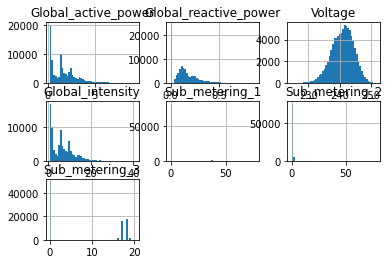

In [5]:
# Check the distribution
plt.figure(figsize=(14,6))
df.hist(bins=50)
plt.title('Global Active Power Distribution')

# plt.subplot(1,2,2)
# stats.probplot(df['Global_active_power'],plot=plt)
# df1.describe().T

In [6]:
#Normalize target value
df['Global_active_power']=normalize_series(df['Global_active_power'], df['Global_active_power'].min(), df['Global_active_power'].max())

In [7]:
df['Voltage'].unique()

array([234.84, 233.63, 233.29, ..., 231.63, 228.51, 231.79])

In [8]:
#Normalize voltage value
#df['Voltage']=normalize_series(df['Voltage'], df['Voltage'].min(), df['Voltage'].max())

In [9]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,0.433779,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,0.557161,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,0.558671,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,0.560181,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,0.374461,0.528,235.68,15.8,0.0,1.0,17.0


In [10]:
N_FEATURES = len(df.columns) # DO NOT CHANGE THIS

    # Normalizes the data
data = df.values
data = normalize_series(data, data.min(axis=0), data.max(axis=0))

    # Splits the data into training and validation sets.
SPLIT_TIME = int(len(data) * 0.5) # DO NOT CHANGE THIS
x_train = data[:SPLIT_TIME]
x_valid = data[SPLIT_TIME:]

    # DO NOT CHANGE THIS CODE
tf.keras.backend.clear_session()
tf.random.set_seed(42)

    # DO NOT CHANGE BATCH_SIZE IF YOU ARE USING STATEFUL LSTM/RNN/GRU.
    # THE TEST WILL FAIL TO GRADE YOUR SCORE IN SUCH CASES.
    # In other cases, it is advised not to change the batch size since it
    # might affect your final scores. While setting it to a lower size
    # might not do any harm, higher sizes might affect your scores.
BATCH_SIZE = 32  # ADVISED NOT TO CHANGE THIS

    # DO NOT CHANGE N_PAST, N_FUTURE, SHIFT. The tests will fail to run
    # on the server.
    # Number of past time steps based on which future observations should be
    # predicted
N_PAST = 24  # DO NOT CHANGE THIS

    # Number of future time steps which are to be predicted.
N_FUTURE = 24  # DO NOT CHANGE THIS

    # By how many positions the window slides to create a new window
    # of observations.
SHIFT = 1  # DO NOT CHANGE THIS

    # Code to create windowed train and validation datasets.
train_set = windowed_dataset(series=x_train, batch_size=BATCH_SIZE,
                                 n_past=N_PAST, n_future=N_FUTURE,
                                 shift=SHIFT)
valid_set = windowed_dataset(series=x_valid, batch_size=BATCH_SIZE,
                                 n_past=N_PAST, n_future=N_FUTURE,
                                 shift=SHIFT)



In [11]:
x_t=[]
y_t=[]
x_v=[]
y_v=[]
for input, label in train_set.unbatch():
  x_t.append(input)
  y_t.append(label)
for input, label in valid_set.unbatch():
  x_v.append(input)
  y_v.append(label)

In [12]:
#x_t=train_set[0]
x_t= np.asarray(x_t)
y_t =np.asarray(y_t)
x_v= np.asarray(x_v)
y_v = np.asarray(y_v)

In [13]:
print(y_v.shape)

(43153, 24, 7)


In [14]:
print(f"Shape of training data: {np.asarray(y_t).shape}")


Shape of training data: (43153, 24, 7)


In [15]:
for element in y_t:
  print(element)
  import sys
  sys.exit()

[[0.47146949 0.         0.04084227 0.46039604 0.         0.
  0.85      ]
 [0.33641771 0.         0.04759634 0.31683168 0.         0.
  0.85      ]
 [0.33509584 0.         0.0443385  0.31683168 0.         0.
  0.85      ]
 [0.33421458 0.         0.04338498 0.31683168 0.         0.
  0.85      ]
 [0.33751928 0.         0.04294795 0.32178218 0.         0.
  0.85      ]
 [0.32870676 0.         0.04211363 0.31188119 0.         0.
  0.85      ]
 [0.27825512 0.         0.04123957 0.26732673 0.         0.
  0.85      ]
 [0.39259749 0.08695652 0.03770362 0.38613861 0.         0.
  0.85      ]
 [0.45692884 0.10297483 0.03611442 0.43564356 0.         0.
  0.8       ]
 [0.47565543 0.         0.03551847 0.45544554 0.         0.
  0.85      ]
 [0.42564442 0.22883295 0.03972984 0.41584158 0.         0.
  0.85      ]
 [0.25093633 0.06636156 0.04870878 0.23762376 0.         0.
  0.85      ]
 [0.28596607 0.20594966 0.05101311 0.27227723 0.         0.
  0.9       ]
 [0.26768011 0.16475973 0.05371474 0.2

SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [16]:
len(y_t)

43153

In [17]:
model = tf.keras.models.Sequential([

        # ADD YOUR LAYERS HERE.

        tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                               strides=1, padding="causal",
                               activation="relu",
                               input_shape=[24, 7]),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),

        # If you don't follow the instructions in the following comments,
        # tests will fail to grade your code:
        # The input layer of your model must have an input shape of:
        # (BATCH_SIZE, N_PAST = 24, N_FEATURES = 7)
        # The model must have an output shape of:
        # (BATCH_SIZE, N_FUTURE = 24, N_FEATURES = 7).
        # Make sure that there are N_FEATURES = 7 neurons in the final dense
        # layer since the model predicts 7 features.

        # HINT: Bidirectional LSTMs may help boost your score. This is only a
        # suggestion.

        # WARNING: If you are using the GRU layer, it is advised not to use the
        # recurrent_dropout argument (you can alternatively set it to 0),
        # since it has not been implemented in the cuDNN kernel and may
        # result in much longer training times.
        tf.keras.layers.Dense(N_FEATURES)
        
    ])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 24, 32)            1152      
                                                                 
 lstm (LSTM)                 (None, 24, 64)            24832     
                                                                 
 lstm_1 (LSTM)               (None, 24, 64)            33024     
                                                                 
 dense (Dense)               (None, 24, 30)            1950      
                                                                 
 dense_1 (Dense)             (None, 24, 10)            310       
                                                                 
 dense_2 (Dense)             (None, 24, 7)             77        
                                                                 
Total params: 61,345
Trainable params: 61,345
Non-traina

In [20]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
cvlog=tf.keras.callbacks.CSVLogger('his.csv')
model.compile(
        # YOUR CODE HERE
         loss="mse", optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5),metrics=[tf.metrics.MeanSquaredError()]
    )

In [95]:
history=model.fit(
        # YOUR CODE HERE
        x_t,y_t, epochs=5,validation_data=(x_v,y_v), callbacks=[ early_stopping, cvlog], verbose=1
    )

Epoch 1/5
1349/1349 [==============================] - 68s 45ms/step - loss: 0.0646 - mean_squared_error: 0.0646 - val_loss: 0.0650 - val_mean_squared_error: 0.0650
Epoch 2/5
1349/1349 [==============================] - 59s 43ms/step - loss: 0.0642 - mean_squared_error: 0.0642 - val_loss: 0.0645 - val_mean_squared_error: 0.0645
Epoch 3/5
1349/1349 [==============================] - 59s 43ms/step - loss: 0.0637 - mean_squared_error: 0.0637 - val_loss: 0.0640 - val_mean_squared_error: 0.0640
Epoch 4/5
1349/1349 [==============================] - 59s 43ms/step - loss: 0.0632 - mean_squared_error: 0.0632 - val_loss: 0.0635 - val_mean_squared_error: 0.0635
Epoch 5/5
1349/1349 [==============================] - 58s 43ms/step - loss: 0.0627 - mean_squared_error: 0.0627 - val_loss: 0.0630 - val_mean_squared_error: 0.0630


In [96]:
import pandas as pd
his = pd.read_csv('his.csv') 
his.head()


,epoch,loss,mean_squared_error,val_loss,val_mean_squared_error
0,0,0.064638,0.064638,0.064961,0.064961
1,1,0.064159,0.064159,0.064460,0.064460
2,2,0.063679,0.063679,0.063960,0.063960
3,3,0.063202,0.063202,0.063466,0.063466
4,4,0.062729,0.062729,0.062979,0.062979


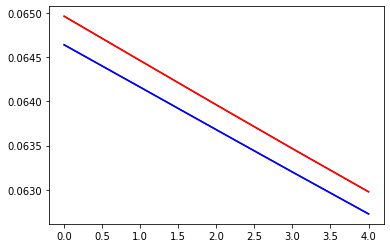

In [97]:
# Plot training and validation metrics from history object

train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_accuracy=history.history['mean_squared_error']
val_accuracy=history.history['val_mean_squared_error']
epochs=range(len(train_accuracy))
#plot loss
plt.plot(epochs,train_loss,color='b',label='Train loss')
plt.plot(epochs,val_loss,color='r',label='Validation loss')
#plot accuracy
plt.plot(epochs,train_accuracy,color='b',label='Train accuracy')
plt.plot(epochs,val_accuracy,color='r',label='Validation accuracy')